<a href="https://colab.research.google.com/github/realtechsupport/cocktail/blob/main/sandbox/notebooks/tf_record_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
image_datapath = '/content/gdrive/MyDrive/exp/other images/test_folder/'

In [3]:
label_datapath = '/content/gdrive/MyDrive/exp/label/image_extent_mask_1123.tif'

In [4]:
geojson_datapath = '/content/gdrive/MyDrive/exp/label/newextent_1123.geojson'

Our image_datapath contains two images in GeoTIFF format containing 8 band data.

Our label_datapath is a label image(embedded in its pixel values) in GeoTIFF format containing class information corresponding to the images in image_datapath

Converting to tf_record:

1. open tiff files using rasterio
2. clip the tiff files to the desired extent prescribed by our geojson file
3. Store the numpy array along with metadata of both image and label in tf.example datastructure


In [6]:
!pip install rasterio

In [5]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping

In [6]:
import tensorflow as tf

In [7]:

def clip_tiff(tiff, geojson = geojson_datapath):

    with open(geojson) as clip_geojson:
        clip_geojson = gpd.read_file(clip_geojson)
        clip_geometry = clip_geojson.geometry.values[0]
        clip_geojson = mapping(clip_geometry)
        print(clip_geojson)

    with rasterio.open(tiff) as src:
        print("input image data before processing", src.meta)

            # Perform the clip
        clip_image, clip_transform = mask(src, [clip_geojson], crop=True)
        print("shape of clipped_image:", clip_image.shape)
        print("extent of clipped image:", clip_transform)
        clip_meta = src.meta.copy()

    clip_meta.update({"driver": "GTiff",
                      "height": clip_image.shape[1],
                      "width": clip_image.shape[2],
                      "transform": clip_transform})
    return clip_image, clip_meta

In [25]:
test_image = '/content/gdrive/MyDrive/exp/other images/test_folder/area2_0803_2022_8bands.tif'

In [8]:
second_test_image = '/content/gdrive/MyDrive/exp/other images/test_folder/area2_0619_2023_8bands_composite.tif'

In [26]:
test_image_out =  clip_tiff(test_image, geojson_datapath)

{'type': 'Polygon', 'coordinates': (((281195.46875, 9080046.0), (294939.9375, 9080046.0), (294939.9375, 9091126.0), (281195.46875, 9091126.0), (281195.46875, 9080046.0)),)}
input image data before processing {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 4686, 'height': 4085, 'count': 8, 'crs': CRS.from_epsg(32750), 'transform': Affine(3.0, 0.0, 280884.0,
       0.0, -3.0, 9091677.0)}
shape of clipped_image: (8, 3694, 4583)
extent of clipped image: | 3.00, 0.00, 281193.00|
| 0.00,-3.00, 9091128.00|
| 0.00, 0.00, 1.00|


In [9]:
second_test_image_out =  clip_tiff(second_test_image, geojson_datapath)

{'type': 'Polygon', 'coordinates': (((281195.46875, 9080046.0), (294939.9375, 9080046.0), (294939.9375, 9091126.0), (281195.46875, 9091126.0), (281195.46875, 9080046.0)),)}
input image data before processing {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 4591, 'height': 4013, 'count': 8, 'crs': CRS.from_epsg(32750), 'transform': Affine(3.0, 0.0, 281025.0,
       0.0, -3.0, 9091659.0)}
shape of clipped_image: (8, 3694, 4535)
extent of clipped image: | 3.00, 0.00, 281193.00|
| 0.00,-3.00, 9091128.00|
| 0.00, 0.00, 1.00|


In [28]:
print(test_image_out[1])

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 4583, 'height': 3694, 'count': 8, 'crs': CRS.from_epsg(32750), 'transform': Affine(3.0, 0.0, 281193.0,
       0.0, -3.0, 9091128.0)}


In [31]:
type(test_image_out[0])

numpy.ndarray

In [13]:
label_image_out = clip_tiff(label_datapath, geojson_datapath)

{'type': 'Polygon', 'coordinates': (((281195.46875, 9080046.0), (294939.9375, 9080046.0), (294939.9375, 9091126.0), (281195.46875, 9091126.0), (281195.46875, 9080046.0)),)}
input image data before processing {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 4686, 'height': 4085, 'count': 1, 'crs': CRS.from_epsg(32750), 'transform': Affine(3.0, 0.0, 280884.0,
       0.0, -3.0, 9091677.0)}
shape of clipped_image: (1, 3694, 4583)
extent of clipped image: | 3.00, 0.00, 281193.00|
| 0.00,-3.00, 9091128.00|
| 0.00, 0.00, 1.00|


In [13]:
label_image_out[1]

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 4642,
 'height': 4020,
 'count': 1,
 'crs': CRS.from_epsg(32750),
 'transform': Affine(2.9611431673448845, 0.0, 281195.479710034,
        0.0, -2.7566563654218252, 9091125.01553164)}

In [14]:
label_image_out[0].shape

(1, 4020, 4642)

In [14]:
tensor_label = tf.convert_to_tensor(label_image_out[0])

In [35]:
tensor_label.shape[1:]

TensorShape([3694, 4583])

In [36]:
tensor_test_image = tf.convert_to_tensor(test_image_out[0])

In [10]:
tensor_second_test_image = tf.convert_to_tensor(second_test_image_out[0])

In [11]:
reshaped_second_test_image = tf.transpose(tensor_second_test_image, perm=[1, 2, 0])

In [20]:
reshaped_second_test_image.shape[:2]

TensorShape([3694, 4535])

In [46]:
tensor_second_test_image.shape

TensorShape([8, 3694, 4535])

In [37]:
tensor_test_image.shape[1:]

TensorShape([3694, 4583])

In [38]:
tensor_label.shape[1:] == tensor_test_image.shape[1:]

True

In [42]:
tensor_label.shape[1]

3694

In [44]:
tensor_test_image.shape

TensorShape([8, 3694, 4583])

In [43]:
tensor_label.shape[2]

4583

In [17]:
resized_8_channel_image = tf.image.resize_with_crop_or_pad(reshaped_second_test_image, tensor_label.shape[1], tensor_label.shape[2])

In [18]:
resized_8_channel_image.shape

TensorShape([3694, 4583, 8])

In [19]:
reshaped_second_test_image.shape

TensorShape([3694, 4535, 8])

In [ ]:
image = tf.image.resize(image, (resize, resize))

GeoJSON geometries overlap with the raster extent.


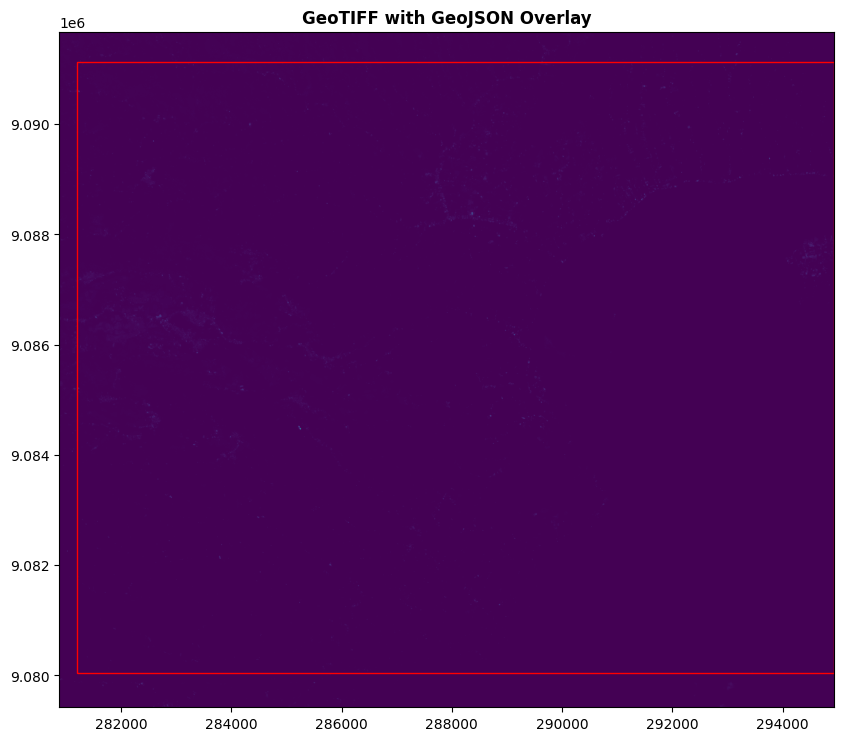

In [29]:

from rasterio.plot import show
import matplotlib.pyplot as plt

# Path to the GeoTIFF file you want to visualize
tiff_path = test_image

# Path to the GeoJSON file for visualization
geojson_path = geojson_datapath

# Read the GeoJSON file
gdf = gpd.read_file(geojson_path)

# Open the GeoTIFF file
with rasterio.open(tiff_path) as src:
    # Check if GeoJSON geometries overlap with the raster extent
    raster_extent = src.bounds
    geojson_extent = gdf.total_bounds

    if (raster_extent[0] > geojson_extent[2] or raster_extent[2] < geojson_extent[0] or
            raster_extent[1] > geojson_extent[3] or raster_extent[3] < geojson_extent[1]):
        print("GeoJSON geometries do not overlap with the raster extent.")
    else:
        print("GeoJSON geometries overlap with the raster extent.")

    # Visualize both GeoTIFF and GeoJSON geometries
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the GeoTIFF
    show(src, ax=ax, title="GeoTIFF with GeoJSON Overlay")

    # Plot the GeoJSON
    gdf.plot(ax=ax, facecolor='none', edgecolor='red')

    plt.show()


In [ ]:
#resizing

def resize_img(
    image: tf.Tensor, label: tf.Tensor, resize: int
) -> Tuple[tf.Tensor, tf.Tensor]:
    image = tf.image.resize(image, (resize, resize))
    label = tf.image.resize(label[..., None], (resize, resize))
    label = tf.squeeze(label, -1)
    return image, label

How to create a tf record:

1. extract the given image and label's numpy data and metadata
2. create a tf.example datastructure that stores the above extracted information
3. write a tf.record
4. parse the tf.record to extract the given image and label and display it

# Task1: extract the information in given image

1. clip the image to the given vector data
2. extract the numpy
3. extract the metadata

# Task2 : extract the information in given label

1. clip the image to the given vector data
2. extract the numpy array
3. extract the metadata

# Task3 : make sure the resize the image to the size of label

# Task 4 : create the tf.example datastructure

1. contains image array, image shape, other meta data
2. contains label array, label shape, other meta data

# Task 5: write the data in tf.example data structure on to a tf.record

# Task 6: deserialize the data and display the label and image

In [ ]:


#take an image, apply clipping function, return numpy array, and meta data
#take the mask, apply clipping function, return numpy array, and meta data
#serialize it

In [67]:
def resize_img(image,label):

  image = tf.image.resize_with_crop_or_pad(image, label.shape[0], label.shape[1])

  return image, label


In [65]:
def process_input(image, label):

    tensor_image = tf.convert_to_tensor(image)
    tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
    tensor_label = tf.convert_to_tensor(label)
    tensor_label = tf.transpose(tensor_label, perm=[1, 2, 0])

    if tensor_label.shape[:2] != tensor_image.shape[:2]:
      tensor_image, tensor_label = resize_img(tensor_image, tensor_label)

    return tensor_image, tensor_label

In [24]:

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


In [25]:
def create_tfrecord(image, label):
    image, label = process_input(image, label)
    image_dims = image.shape
    label_dims = label.shape

    image = tf.reshape(image, [-1])  # flatten to 1D array
    label = tf.reshape(label, [-1])  # flatten to 1D array

    return tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": _float_feature(image.numpy()),
                "image_shape": _int64_feature(
                    [image_dims[0], image_dims[1], image_dims[2]]
                ),
                "label": _float_feature(label.numpy()),
                "label_shape": _int64_feature([label_dims[0], label_dims[1], label_dims[2]]),
            }
        )
    ).SerializeToString()

In [59]:
tensor_image = tf.convert_to_tensor(images[0])
tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
tensor_image.shape

TensorShape([3694, 4535, 8])

In [60]:
tensor_label = tf.convert_to_tensor(labels[0])
tensor_label = tf.transpose(tensor_label, perm=[1, 2, 0])


In [62]:
tensor_label.shape

TensorShape([3694, 4583, 1])

In [63]:
tensor_label.shape[:2] == tensor_image.shape[:2]


False

In [ ]:
image = tf.image.resize_with_crop_or_pad(tensor_image, tensor_label.shape[1], tensor_label.shape[2])

In [55]:
image, label = process_input(images[0],labels[0])
image_dims = image.shape
label_dims = label.shape

image = tf.reshape(image, [-1])  # flatten to 1D array
label = tf.reshape(label, [-1])  # flatten to 1D array

In [57]:
label_dims

TensorShape([3694, 4583, 1])

In [56]:
image_dims

TensorShape([4583, 1, 8])

In [54]:
output_file = 'output.tfrecord'
images = [second_test_image_out[0]]
labels = [label_image_out[0]]

In [27]:
images[0].shape

(8, 3694, 4535)

In [30]:
labels[0].shape

(1, 3694, 4583)

In [66]:
# Example usage to create TFRecord files
def write_tfrecords(images, labels, output_file):
    with tf.io.TFRecordWriter(output_file) as writer:
        for image, label in zip(images, labels):
            tf_example = create_tfrecord(image, label)
            writer.write(tf_example)

In [68]:
write_tfrecords(images, labels, output_file)

TypeError: ignored

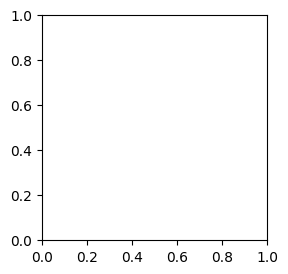

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the functions _float_feature and _int64_feature defined

# Define functions to parse the TFRecord
def parse_tfr(proto):
    feature_description = {
        "image": tf.io.VarLenFeature(tf.float32),
        "image_shape": tf.io.VarLenFeature(tf.int64),
        "label": tf.io.VarLenFeature(tf.float32),
        "label_shape": tf.io.VarLenFeature(tf.int64),
    }
    rec = tf.io.parse_single_example(proto, feature_description)
    image_shape = tf.sparse.to_dense(rec["image_shape"])
    image = tf.reshape(tf.sparse.to_dense(rec["image"]), image_shape)
    label_shape = tf.sparse.to_dense(rec["label_shape"])
    label = tf.reshape(tf.sparse.to_dense(rec["label"]), label_shape)
    return {"pixel_values": image, "label": label}

# Function to display the 8-band image and label
def display_image_and_label(image, label):
    # Your display logic goes here
    # You can use matplotlib or any other library to visualize the images
    plt.subplot(1, 2, 1)
    plt.imshow(np.asarray(image), cmap='gray')
    plt.title('8-Band Image')

    plt.subplot(1, 2, 2)
    plt.imshow(np.asarray(label), cmap='gray')
    plt.title('Label')

    plt.show()

# Example usage to read and display the TFRecord file
def read_and_display_tfrecord(tfrecord_file):
    # Create a TFRecordDataset
    dataset = tf.data.TFRecordDataset(tfrecord_file)

    # Map the parsing function to the dataset
    parsed_dataset = dataset.map(parse_tfr)

    # Iterate through the dataset and display images and labels
    for image, label in parsed_dataset:
        display_image_and_label(image, label)

# Example usage:
# Specify the path to your TFRecord file
tfrecord_file = '/content/output.tfrecord'

# Read and display the TFRecord file
read_and_display_tfrecord(tfrecord_file)


In [44]:
dataset = tf.data.TFRecordDataset(tfrecord_file)

In [37]:
dataset.shape

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [45]:
parsed_dataset = dataset.map(parse_tfr)


In [49]:
parsed_dataset


<_MapDataset element_spec={'pixel_values': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'label': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)}>

In [69]:
feature_description = {
        "image": tf.io.VarLenFeature(tf.float32),
        "image_shape": tf.io.VarLenFeature(tf.int64),
        "label": tf.io.VarLenFeature(tf.float32),
        "label_shape": tf.io.VarLenFeature(tf.int64),
    }

for serialized_example in tf.data.TFRecordDataset(['/content/output.tfrecord']):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [51]:
parsed_example

{'image': SparseTensor(indices=tf.Tensor(
 [[    0]
  [    1]
  [    2]
  ...
  [36661]
  [36662]
  [36663]], shape=(36664, 1), dtype=int64), values=tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(36664,), dtype=float32), dense_shape=tf.Tensor([36664], shape=(1,), dtype=int64)),
 'image_shape': SparseTensor(indices=tf.Tensor(
 [[0]
  [1]
  [2]], shape=(3, 1), dtype=int64), values=tf.Tensor([4583    1    8], shape=(3,), dtype=int64), dense_shape=tf.Tensor([3], shape=(1,), dtype=int64)),
 'label': SparseTensor(indices=tf.Tensor(
 [[       0]
  [       1]
  [       2]
  ...
  [16929599]
  [16929600]
  [16929601]], shape=(16929602, 1), dtype=int64), values=tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(16929602,), dtype=float32), dense_shape=tf.Tensor([16929602], shape=(1,), dtype=int64)),
 'label_shape': SparseTensor(indices=tf.Tensor(
 [[0]
  [1]
  [2]], shape=(3, 1), dtype=int64), values=tf.Tensor([3694 4583    1], shape=(3,), dtype=int64), dense_shape=tf.Tensor([3], shape=(1,), dtype=int64))}

In [70]:

image_shape = tf.sparse.to_dense(parsed_example["image_shape"])
image = tf.reshape(tf.sparse.to_dense(parsed_example["image"]), image_shape)

In [52]:
image_shape = tf.sparse.to_dense(parsed_example["image_shape"])

In [71]:
image_shape

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([3694, 4583,    8])>

In [75]:
label_shape = tf.sparse.to_dense(parsed_example["label_shape"])
label = tf.reshape(tf.sparse.to_dense(parsed_example["label"]), label_shape)

In [76]:
label.shape

TensorShape([3694, 4583, 1])

In [77]:
label = tf.squeeze(label, -1)

Text(0.5, 1.0, 'Label')

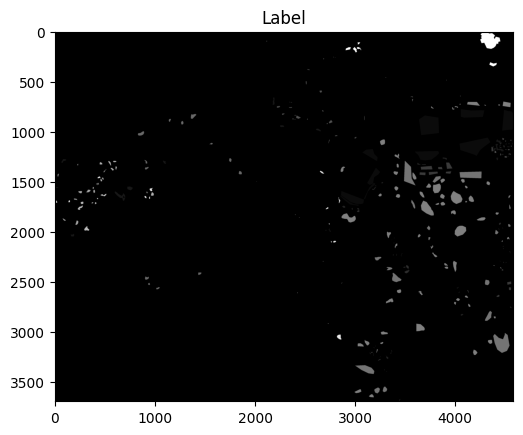

In [78]:
plt.imshow(np.asarray(label), cmap='gray')
plt.title('Label')

# tf record pipeline: Successfully created tf records that contains image and mask of same size

# this segment of the pipeline consists of these functions:

1. clipping
2. processing image and label to make them same size
3. converting to tf record

In [ ]:
!pip install rasterio

In [95]:
#imports

import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import tensorflow as tf

In [96]:


def clip_tiff(tiff, geojson = geojson_datapath):

    with open(geojson) as clip_geojson:
        clip_geojson = gpd.read_file(clip_geojson)
        clip_geometry = clip_geojson.geometry.values[0]
        clip_geojson = mapping(clip_geometry)
        #print(clip_geojson)

    with rasterio.open(tiff) as src:
        #print("input image data before processing", src.meta)

        # Perform the clip
        clip_image, clip_transform = mask(src, [clip_geojson], crop=True)
        #print("shape of clipped_image:", clip_image.shape)
        #print("extent of clipped image:", clip_transform)
        #clip_meta = src.meta.copy()

    # clip_meta.update({"driver": "GTiff",
    #                   "height": clip_image.shape[1],
    #                   "width": clip_image.shape[2],
    #                   "transform": clip_transform})
    return clip_image

In [97]:
# preprocessing functions

def resize_img(image,label):

  image = tf.image.resize_with_crop_or_pad(image, label.shape[0], label.shape[1])

  return image, label


def process_input(image, label):

    tensor_image = tf.convert_to_tensor(image)
    tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
    tensor_label = tf.convert_to_tensor(label)
    tensor_label = tf.transpose(tensor_label, perm=[1, 2, 0])

    if tensor_label.shape[:2] != tensor_image.shape[:2]:
      tensor_image, tensor_label = resize_img(tensor_image, tensor_label)

    return tensor_image, tensor_label


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_tfrecord(image, label):
    image = clip_tiff(image)
    label = clip_tiff(label)
    image, label = process_input(image, label)
    image_dims = image.shape
    label_dims = label.shape

    image = tf.reshape(image, [-1])  # flatten to 1D array
    label = tf.reshape(label, [-1])  # flatten to 1D array

    return tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": _float_feature(image.numpy()),
                "image_shape": _int64_feature(
                    [image_dims[0], image_dims[1], image_dims[2]]
                ),
                "label": _float_feature(label.numpy()),
                "label_shape": _int64_feature([label_dims[0], label_dims[1], label_dims[2]]),
            }
        )
    ).SerializeToString()

In [98]:
import glob

# Specify the folder path where your images are located
folder_path = '/content/gdrive/MyDrive/exp/other images/test_folder/'

# Use glob to get all paths of .tif files in the folder
images = glob.glob(folder_path + '*.tif')

number_of_images = len(images)

In [99]:

# Specify the folder path where your images are located
label_folder = '/content/gdrive/MyDrive/exp/label/'

# Use glob to get all paths of .tif files in the folder
labels = glob.glob(label_folder + '*.tif')

labels = labels*number_of_images

In [100]:
geojson_datapath = '/content/gdrive/MyDrive/exp/label/newextent_1123.geojson'

output_file = '/content/gdrive/MyDrive/exp/output.tfrecord'

In [101]:
# create TFRecord files
def write_tfrecords(images, labels, output_file):
    with tf.io.TFRecordWriter(output_file) as writer:
        for image, label in zip(images, labels):
            tf_example = create_tfrecord(image, label)
            writer.write(tf_example)


In [103]:
write_tfrecords(images, labels, output_file)

In [ ]:

# Define functions to parse the TFRecord
def parse_tfr(proto):
    feature_description = {
        "image": tf.io.VarLenFeature(tf.float32),
        "image_shape": tf.io.VarLenFeature(tf.int64),
        "label": tf.io.VarLenFeature(tf.float32),
        "label_shape": tf.io.VarLenFeature(tf.int64),
    }
    rec = tf.io.parse_single_example(proto, feature_description)
    image_shape = tf.sparse.to_dense(rec["image_shape"])
    image = tf.reshape(tf.sparse.to_dense(rec["image"]), image_shape)
    label_shape = tf.sparse.to_dense(rec["label_shape"])
    label = tf.reshape(tf.sparse.to_dense(rec["label"]), label_shape)
    return {"pixel_values": image, "label": label}

In [104]:
# for serialized_example in tf.data.TFRecordDataset(['/content/gdrive/MyDrive/exp/output.tfrecord']):
#     parsed_example = tf.io.parse_single_example(serialized_example,
#                                                 feature_description)